# Hybrid transfer learning for image classification (CIFAR)

This is an example of a hybrid network for image classification, developed according to the *classical-to-quantum transfer learning* scheme presented in [1].

This notebook is inspired by the official PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy [2].

## General setup

In [ ]:
# install pennylane
!pip install pennylane==0.28

In [17]:
# OpenMP: number of parallel threads.
#%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


### Please choose and run only one of the following two cells, depending on the dataset of interest.

In [66]:
filtered_classes = ['bear', 'tiger']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = False                     # If set to "False", the dressed quantum circuit is replaced by
                                   # An enterily classical net (defined by the next parameter).
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

Let us initialize a PennyLane with the default simulator.

In [4]:
dev = qml.device('default.qubit', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset loading

**Remark:** It may take several minutes to download the CIFAR dataset (only the first time).
The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [6]:
# Fixed pre-processing operations
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3, 88
# =================== begin CIFAR dataset loading ===================
trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
#class_names = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of samples associated to filtered_classes
filtered_labels=[3, 88]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):
        if label in filtered_labels:
            sub_indices[phase].append(idx)

# Initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
# =================== end CIFAR dataset loading ==========================

# Number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from tensors
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

100%|██████████| 169001437/169001437 [00:02<00:00, 81719523.81it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

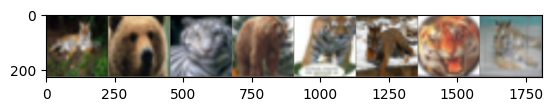

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#imshow(out, title=[class_names[x] for x in classes])
imshow(out)

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [9]:
@qml.qnode(dev, interface='torch', diff_method="backprop")
def q_net(q_in, q_weights_flat):

        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)

        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)

        # Embed features in the quantum node
        RY_layer(q_in)

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

## QCNN


In [104]:
@qml.qnode(dev, interface='torch', diff_method="backprop")
def qcnn(q_in, q_weights_flat):

        # Reshape weights
        q_weights = q_weights_flat.reshape(15, n_qubits)

        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)

        # Embed features in the quantum node
        RY_layer(q_in)

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k])

        qml.CNOT(wires=[0, 3])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(0))]

In [190]:
class QCNNnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            #self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0

            #print('qin size: ', q_in.shape)

            #print('qcirc shape: ', qcnn(q_in[0] ,self.q_params).shape)

            # Apply the quantum circuit to each element of the batch, and append to q_out
            #q_out = torch.Tensor(0, n_qubits)
            q_out = []

            #"""
            for elem in q_in:
                q_out_elem = qcnn(elem, self.q_params).float()
                if q_out_elem > 0:
                  q_out_elem = 1
                else:
                  q_out_elem = 0
                q_out.append(int(q_out_elem))
                #print('qout: ', q_out)
                #q_out_elem = nn.functional.relu(q_out_elem)
                #q_out = q_out_elem
                #q_out = torch.cat((q_out, q_out_elem))
                #q_out = torch.Tensor(q_out)
                #print('qout size: ', q_out.shape)
            #"""
            #return torch.LongTensor(q_out)
            return torch.Tensor(q_out)

In [191]:
model_qcnn = torchvision.models.resnet18(pretrained=True)

for param in model_qcnn.parameters():
    param.requires_grad = False

model_qcnn.fc = QCNNnet()

In [192]:
criterion = nn.BCELoss()
optimizer_hybrid = optim.Adam(model_qcnn.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

In [193]:
def train_qcnn(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train()
                else:
                    # Set model to evaluate mode
                    model.eval()

                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in tqdm(dataloaders[phase]):
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        print('output: ', outputs)
                        #_, preds = torch.max(outputs, 1)
                        print('labels: ', labels)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss

        # Print final results
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [ ]:
model_qcnn = train_qcnn(model_qcnn, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=5)

In [10]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0

            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [26]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [27]:
criterion = nn.CrossEntropyLoss()

We also initialize the *optimizer* which is called at each training step in order to update the weights of the model.

In [28]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every epoch.

In [29]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications).

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train()
                else:
                    # Set model to evaluate mode
                    model.eval()

                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in tqdm(dataloaders[phase]):
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss

        # Print final results
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

We are ready perform the actual training process.

In [32]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=5)

Training started:


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:01<02:24,  1.16s/it]

  2%|▏         | 2/125 [00:01<01:56,  1.05it/s]

  2%|▏         | 3/125 [00:02<01:42,  1.19it/s]

  3%|▎         | 4/125 [00:03<01:36,  1.25it/s]

  4%|▍         | 5/125 [00:04<01:32,  1.30it/s]

  5%|▍         | 6/125 [00:04<01:30,  1.31it/s]

  6%|▌         | 7/125 [00:05<01:28,  1.33it/s]

  6%|▋         | 8/125 [00:06<01:25,  1.36it/s]

  7%|▋         | 9/125 [00:06<01:23,  1.39it/s]

  8%|▊         | 10/125 [00:07<01:22,  1.40it/s]

  9%|▉         | 11/125 [00:08<01:21,  1.39it/s]

 10%|▉         | 12/125 [00:09<01:20,  1.40it/s]

 10%|█         | 13/125 [00:09<01:19,  1.41it/s]

 11%|█         | 14/125 [00:10<01:19,  1.40it/s]

 12%|█▏        | 15/125 [00:11<01:18,  1.39it/s]

 13%|█▎        | 16/125 [00:12<01:29,  1.22it/s]

 14%|█▎        | 17/125 [00:13<01:39,  1.08it/s]

 14%|█▍        | 18/125 [00:14<01:48,  1.01s/it]

 15%|█▌        | 19/125 [00:15<01:50,  1.04s/it]

 16%|█▌        | 20/125 [00:16<01:49,  1.04s/it]

 17%|█▋        | 21/125 [00:17<01:37,  1.07it/s]

 18%|█▊        | 22/125 [00:18<01:29,  1.15it/s]

 18%|█▊        | 23/125 [00:18<01:23,  1.22it/s]

 19%|█▉        | 24/125 [00:19<01:18,  1.28it/s]

 20%|██        | 25/125 [00:20<01:16,  1.31it/s]

 21%|██        | 26/125 [00:21<01:14,  1.33it/s]

 22%|██▏       | 27/125 [00:21<01:12,  1.34it/s]

 22%|██▏       | 28/125 [00:22<01:11,  1.36it/s]

 23%|██▎       | 29/125 [00:23<01:10,  1.36it/s]

 24%|██▍       | 30/125 [00:24<01:09,  1.37it/s]

 25%|██▍       | 31/125 [00:24<01:08,  1.38it/s]

 26%|██▌       | 32/125 [00:25<01:07,  1.38it/s]

 26%|██▋       | 33/125 [00:26<01:06,  1.38it/s]

 27%|██▋       | 34/125 [00:26<01:05,  1.38it/s]

 28%|██▊       | 35/125 [00:28<01:18,  1.15it/s]

 29%|██▉       | 36/125 [00:29<01:22,  1.07it/s]

 30%|██▉       | 37/125 [00:30<01:28,  1.01s/it]

 30%|███       | 38/125 [00:31<01:30,  1.04s/it]

 31%|███       | 39/125 [00:32<01:27,  1.01s/it]

 32%|███▏      | 40/125 [00:33<01:18,  1.08it/s]

 33%|███▎      | 41/125 [00:33<01:12,  1.16it/s]

 34%|███▎      | 42/125 [00:34<01:08,  1.22it/s]

 34%|███▍      | 43/125 [00:35<01:04,  1.26it/s]

 35%|███▌      | 44/125 [00:36<01:02,  1.30it/s]

 36%|███▌      | 45/125 [00:36<01:00,  1.33it/s]

 37%|███▋      | 46/125 [00:37<00:58,  1.35it/s]

 38%|███▊      | 47/125 [00:38<00:57,  1.35it/s]

 38%|███▊      | 48/125 [00:38<00:56,  1.36it/s]

 39%|███▉      | 49/125 [00:39<00:55,  1.38it/s]

 40%|████      | 50/125 [00:40<00:53,  1.39it/s]

 41%|████      | 51/125 [00:41<00:53,  1.40it/s]

 42%|████▏     | 52/125 [00:41<00:52,  1.38it/s]

 42%|████▏     | 53/125 [00:42<00:58,  1.24it/s]

 43%|████▎     | 54/125 [00:43<01:05,  1.09it/s]

 44%|████▍     | 55/125 [00:45<01:09,  1.00it/s]

 45%|████▍     | 56/125 [00:46<01:11,  1.04s/it]

 46%|████▌     | 57/125 [00:47<01:11,  1.05s/it]

 46%|████▋     | 58/125 [00:48<01:04,  1.04it/s]

 47%|████▋     | 59/125 [00:48<00:58,  1.12it/s]

 48%|████▊     | 60/125 [00:49<00:54,  1.18it/s]

 49%|████▉     | 61/125 [00:50<00:51,  1.25it/s]

 50%|████▉     | 62/125 [00:50<00:48,  1.29it/s]

 50%|█████     | 63/125 [00:51<00:46,  1.32it/s]

 51%|█████     | 64/125 [00:52<00:45,  1.34it/s]

 52%|█████▏    | 65/125 [00:53<00:44,  1.35it/s]

 53%|█████▎    | 66/125 [00:53<00:43,  1.37it/s]

 54%|█████▎    | 67/125 [00:54<00:41,  1.38it/s]

 54%|█████▍    | 68/125 [00:55<00:41,  1.38it/s]

 55%|█████▌    | 69/125 [00:55<00:40,  1.40it/s]

 56%|█████▌    | 70/125 [00:56<00:39,  1.40it/s]

 57%|█████▋    | 71/125 [00:57<00:38,  1.39it/s]

 58%|█████▊    | 72/125 [00:58<00:45,  1.17it/s]

 58%|█████▊    | 73/125 [00:59<00:48,  1.07it/s]

 59%|█████▉    | 74/125 [01:00<00:51,  1.01s/it]

 60%|██████    | 75/125 [01:02<00:52,  1.04s/it]

 61%|██████    | 76/125 [01:02<00:49,  1.01s/it]

 62%|██████▏   | 77/125 [01:03<00:44,  1.08it/s]

 62%|██████▏   | 78/125 [01:04<00:40,  1.15it/s]

 63%|██████▎   | 79/125 [01:05<00:37,  1.22it/s]

 64%|██████▍   | 80/125 [01:05<00:35,  1.27it/s]

 65%|██████▍   | 81/125 [01:06<00:33,  1.30it/s]

 66%|██████▌   | 82/125 [01:07<00:32,  1.33it/s]

 66%|██████▋   | 83/125 [01:07<00:31,  1.34it/s]

 67%|██████▋   | 84/125 [01:08<00:30,  1.35it/s]

 68%|██████▊   | 85/125 [01:09<00:29,  1.36it/s]

 69%|██████▉   | 86/125 [01:10<00:28,  1.36it/s]

 70%|██████▉   | 87/125 [01:10<00:27,  1.37it/s]

 70%|███████   | 88/125 [01:11<00:26,  1.37it/s]

 71%|███████   | 89/125 [01:12<00:26,  1.38it/s]

 72%|███████▏  | 90/125 [01:13<00:27,  1.25it/s]

 73%|███████▎  | 91/125 [01:14<00:31,  1.10it/s]

 74%|███████▎  | 92/125 [01:15<00:32,  1.01it/s]

 74%|███████▍  | 93/125 [01:16<00:32,  1.02s/it]

 75%|███████▌  | 94/125 [01:17<00:32,  1.05s/it]

 76%|███████▌  | 95/125 [01:18<00:29,  1.03it/s]

 77%|███████▋  | 96/125 [01:19<00:26,  1.11it/s]

 78%|███████▊  | 97/125 [01:20<00:23,  1.18it/s]

 78%|███████▊  | 98/125 [01:20<00:21,  1.23it/s]

 79%|███████▉  | 99/125 [01:21<00:20,  1.27it/s]

 80%|████████  | 100/125 [01:22<00:19,  1.30it/s]

 81%|████████  | 101/125 [01:23<00:18,  1.32it/s]

 82%|████████▏ | 102/125 [01:23<00:17,  1.33it/s]

 82%|████████▏ | 103/125 [01:24<00:16,  1.34it/s]

 83%|████████▎ | 104/125 [01:25<00:15,  1.35it/s]

 84%|████████▍ | 105/125 [01:25<00:14,  1.36it/s]

 85%|████████▍ | 106/125 [01:26<00:13,  1.38it/s]

 86%|████████▌ | 107/125 [01:27<00:13,  1.38it/s]

 86%|████████▋ | 108/125 [01:28<00:12,  1.36it/s]

 87%|████████▋ | 109/125 [01:29<00:14,  1.14it/s]

 88%|████████▊ | 110/125 [01:30<00:14,  1.07it/s]

 89%|████████▉ | 111/125 [01:31<00:13,  1.01it/s]

 90%|████████▉ | 112/125 [01:32<00:13,  1.03s/it]

 90%|█████████ | 113/125 [01:33<00:11,  1.00it/s]

 91%|█████████ | 114/125 [01:34<00:10,  1.08it/s]

 92%|█████████▏| 115/125 [01:35<00:08,  1.16it/s]

 93%|█████████▎| 116/125 [01:35<00:07,  1.22it/s]

 94%|█████████▎| 117/125 [01:36<00:06,  1.26it/s]

 94%|█████████▍| 118/125 [01:37<00:05,  1.29it/s]

 95%|█████████▌| 119/125 [01:37<00:04,  1.33it/s]

 96%|█████████▌| 120/125 [01:38<00:03,  1.36it/s]

 97%|█████████▋| 121/125 [01:39<00:02,  1.39it/s]

 98%|█████████▊| 122/125 [01:40<00:02,  1.39it/s]

 98%|█████████▊| 123/125 [01:40<00:01,  1.38it/s]

 99%|█████████▉| 124/125 [01:41<00:00,  1.38it/s]

100%|██████████| 125/125 [01:42<00:00,  1.22it/s]


Phase: train Epoch: 1/5 Loss: 0.3959 Acc: 0.8300             


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:15,  1.54it/s]

  8%|▊         | 2/25 [00:01<00:17,  1.33it/s]

 12%|█▏        | 3/25 [00:02<00:19,  1.11it/s]

 16%|█▌        | 4/25 [00:03<00:19,  1.08it/s]

 20%|██        | 5/25 [00:04<00:19,  1.03it/s]

 24%|██▍       | 6/25 [00:05<00:18,  1.01it/s]

 28%|██▊       | 7/25 [00:06<00:17,  1.03it/s]

 32%|███▏      | 8/25 [00:07<00:15,  1.10it/s]

 36%|███▌      | 9/25 [00:08<00:15,  1.03it/s]

 40%|████      | 10/25 [00:09<00:14,  1.03it/s]

 44%|████▍     | 11/25 [00:10<00:14,  1.00s/it]

 48%|████▊     | 12/25 [00:11<00:13,  1.01s/it]

 52%|█████▏    | 13/25 [00:12<00:11,  1.00it/s]

 56%|█████▌    | 14/25 [00:13<00:09,  1.13it/s]

 60%|██████    | 15/25 [00:13<00:08,  1.23it/s]

 64%|██████▍   | 16/25 [00:14<00:06,  1.31it/s]

 68%|██████▊   | 17/25 [00:15<00:05,  1.37it/s]

 72%|███████▏  | 18/25 [00:15<00:04,  1.43it/s]

 76%|███████▌  | 19/25 [00:16<00:04,  1.47it/s]

 80%|████████  | 20/25 [00:17<00:03,  1.29it/s]

 84%|████████▍ | 21/25 [00:18<00:03,  1.18it/s]

 88%|████████▊ | 22/25 [00:19<00:02,  1.09it/s]

 92%|█████████▏| 23/25 [00:20<00:01,  1.08it/s]

 96%|█████████▌| 24/25 [00:21<00:00,  1.05it/s]

100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Phase: val   Epoch: 1/5 Loss: 0.2438 Acc: 0.9300             


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:00<01:30,  1.36it/s]

  2%|▏         | 2/125 [00:01<01:29,  1.37it/s]

  2%|▏         | 3/125 [00:02<01:29,  1.36it/s]

  3%|▎         | 4/125 [00:02<01:29,  1.35it/s]

  4%|▍         | 5/125 [00:03<01:27,  1.37it/s]

  5%|▍         | 6/125 [00:04<01:27,  1.36it/s]

  6%|▌         | 7/125 [00:05<01:27,  1.34it/s]

  6%|▋         | 8/125 [00:05<01:26,  1.35it/s]

  7%|▋         | 9/125 [00:06<01:26,  1.34it/s]

  8%|▊         | 10/125 [00:07<01:24,  1.36it/s]

  9%|▉         | 11/125 [00:08<01:24,  1.35it/s]

 10%|▉         | 12/125 [00:08<01:23,  1.35it/s]

 10%|█         | 13/125 [00:09<01:23,  1.34it/s]

 11%|█         | 14/125 [00:10<01:39,  1.12it/s]

 12%|█▏        | 15/125 [00:11<01:45,  1.04it/s]

 13%|█▎        | 16/125 [00:13<01:52,  1.03s/it]

 14%|█▎        | 17/125 [00:14<01:54,  1.06s/it]

 14%|█▍        | 18/125 [00:15<01:48,  1.01s/it]

 15%|█▌        | 19/125 [00:15<01:38,  1.07it/s]

 16%|█▌        | 20/125 [00:16<01:31,  1.14it/s]

 17%|█▋        | 21/125 [00:17<01:26,  1.20it/s]

 18%|█▊        | 22/125 [00:18<01:23,  1.24it/s]

 18%|█▊        | 23/125 [00:18<01:20,  1.27it/s]

 19%|█▉        | 24/125 [00:19<01:17,  1.30it/s]

 20%|██        | 25/125 [00:20<01:15,  1.32it/s]

 21%|██        | 26/125 [00:21<01:14,  1.32it/s]

 22%|██▏       | 27/125 [00:21<01:13,  1.33it/s]

 22%|██▏       | 28/125 [00:22<01:12,  1.35it/s]

 23%|██▎       | 29/125 [00:23<01:10,  1.36it/s]

 24%|██▍       | 30/125 [00:24<01:09,  1.36it/s]

 25%|██▍       | 31/125 [00:24<01:08,  1.36it/s]

 26%|██▌       | 32/125 [00:25<01:21,  1.15it/s]

 26%|██▋       | 33/125 [00:27<01:26,  1.06it/s]

 27%|██▋       | 34/125 [00:28<01:32,  1.02s/it]

 28%|██▊       | 35/125 [00:29<01:34,  1.05s/it]

 29%|██▉       | 36/125 [00:30<01:30,  1.01s/it]

 30%|██▉       | 37/125 [00:31<01:22,  1.07it/s]

 30%|███       | 38/125 [00:31<01:15,  1.15it/s]

 31%|███       | 39/125 [00:32<01:11,  1.20it/s]

 32%|███▏      | 40/125 [00:33<01:08,  1.25it/s]

 33%|███▎      | 41/125 [00:33<01:05,  1.28it/s]

 34%|███▎      | 42/125 [00:34<01:03,  1.31it/s]

 34%|███▍      | 43/125 [00:35<01:01,  1.32it/s]

 35%|███▌      | 44/125 [00:36<01:01,  1.32it/s]

 36%|███▌      | 45/125 [00:36<00:59,  1.35it/s]

 37%|███▋      | 46/125 [00:37<00:59,  1.34it/s]

 38%|███▊      | 47/125 [00:38<00:57,  1.35it/s]

 38%|███▊      | 48/125 [00:39<00:56,  1.35it/s]

 39%|███▉      | 49/125 [00:39<00:55,  1.36it/s]

 40%|████      | 50/125 [00:41<01:04,  1.17it/s]

 41%|████      | 51/125 [00:42<01:09,  1.06it/s]

 42%|████▏     | 52/125 [00:43<01:14,  1.02s/it]

 42%|████▏     | 53/125 [00:44<01:15,  1.06s/it]

 43%|████▎     | 54/125 [00:45<01:13,  1.04s/it]

 44%|████▍     | 55/125 [00:46<01:06,  1.05it/s]

 45%|████▍     | 56/125 [00:46<01:01,  1.13it/s]

 46%|████▌     | 57/125 [00:47<00:56,  1.19it/s]

 46%|████▋     | 58/125 [00:48<00:54,  1.24it/s]

 47%|████▋     | 59/125 [00:49<00:51,  1.27it/s]

 48%|████▊     | 60/125 [00:49<00:50,  1.29it/s]

 49%|████▉     | 61/125 [00:50<00:48,  1.32it/s]

 50%|████▉     | 62/125 [00:51<00:47,  1.32it/s]

 50%|█████     | 63/125 [00:52<00:46,  1.34it/s]

 51%|█████     | 64/125 [00:52<00:45,  1.34it/s]

 52%|█████▏    | 65/125 [00:53<00:44,  1.35it/s]

 53%|█████▎    | 66/125 [00:54<00:43,  1.35it/s]

 54%|█████▎    | 67/125 [00:55<00:42,  1.35it/s]

 54%|█████▍    | 68/125 [00:56<00:47,  1.19it/s]

 55%|█████▌    | 69/125 [00:57<00:52,  1.07it/s]

 56%|█████▌    | 70/125 [00:58<00:56,  1.03s/it]

 57%|█████▋    | 71/125 [00:59<00:57,  1.06s/it]

 58%|█████▊    | 72/125 [01:00<00:55,  1.05s/it]

 58%|█████▊    | 73/125 [01:01<00:49,  1.04it/s]

 59%|█████▉    | 74/125 [01:02<00:45,  1.11it/s]

 60%|██████    | 75/125 [01:02<00:42,  1.17it/s]

 61%|██████    | 76/125 [01:03<00:40,  1.22it/s]

 62%|██████▏   | 77/125 [01:04<00:38,  1.26it/s]

 62%|██████▏   | 78/125 [01:05<00:36,  1.29it/s]

 63%|██████▎   | 79/125 [01:05<00:35,  1.31it/s]

 64%|██████▍   | 80/125 [01:06<00:33,  1.33it/s]

 65%|██████▍   | 81/125 [01:07<00:32,  1.34it/s]

 66%|██████▌   | 82/125 [01:08<00:32,  1.34it/s]

 66%|██████▋   | 83/125 [01:08<00:31,  1.34it/s]

 67%|██████▋   | 84/125 [01:09<00:30,  1.35it/s]

 68%|██████▊   | 85/125 [01:10<00:29,  1.36it/s]

 69%|██████▉   | 86/125 [01:11<00:32,  1.19it/s]

 70%|██████▉   | 87/125 [01:12<00:35,  1.07it/s]

 70%|███████   | 88/125 [01:13<00:38,  1.03s/it]

 71%|███████   | 89/125 [01:14<00:38,  1.06s/it]

 72%|███████▏  | 90/125 [01:15<00:36,  1.05s/it]

 73%|███████▎  | 91/125 [01:16<00:32,  1.04it/s]

 74%|███████▎  | 92/125 [01:17<00:29,  1.12it/s]

 74%|███████▍  | 93/125 [01:18<00:26,  1.19it/s]

 75%|███████▌  | 94/125 [01:18<00:25,  1.23it/s]

 76%|███████▌  | 95/125 [01:19<00:23,  1.28it/s]

 77%|███████▋  | 96/125 [01:20<00:22,  1.30it/s]

 78%|███████▊  | 97/125 [01:21<00:21,  1.31it/s]

 78%|███████▊  | 98/125 [01:21<00:20,  1.33it/s]

 79%|███████▉  | 99/125 [01:22<00:19,  1.34it/s]

 80%|████████  | 100/125 [01:23<00:18,  1.34it/s]

 81%|████████  | 101/125 [01:24<00:17,  1.35it/s]

 82%|████████▏ | 102/125 [01:24<00:16,  1.35it/s]

 82%|████████▏ | 103/125 [01:25<00:16,  1.37it/s]

 83%|████████▎ | 104/125 [01:26<00:17,  1.22it/s]

 84%|████████▍ | 105/125 [01:27<00:18,  1.08it/s]

 85%|████████▍ | 106/125 [01:28<00:19,  1.03s/it]

 86%|████████▌ | 107/125 [01:30<00:18,  1.05s/it]

 86%|████████▋ | 108/125 [01:31<00:17,  1.06s/it]

 87%|████████▋ | 109/125 [01:31<00:15,  1.05it/s]

 88%|████████▊ | 110/125 [01:32<00:13,  1.12it/s]

 89%|████████▉ | 111/125 [01:33<00:11,  1.18it/s]

 90%|████████▉ | 112/125 [01:34<00:10,  1.23it/s]

 90%|█████████ | 113/125 [01:34<00:09,  1.27it/s]

 91%|█████████ | 114/125 [01:35<00:08,  1.30it/s]

 92%|█████████▏| 115/125 [01:36<00:07,  1.31it/s]

 93%|█████████▎| 116/125 [01:37<00:06,  1.32it/s]

 94%|█████████▎| 117/125 [01:37<00:06,  1.33it/s]

 94%|█████████▍| 118/125 [01:38<00:05,  1.33it/s]

 95%|█████████▌| 119/125 [01:39<00:04,  1.35it/s]

 96%|█████████▌| 120/125 [01:39<00:03,  1.36it/s]

 97%|█████████▋| 121/125 [01:40<00:02,  1.36it/s]

 98%|█████████▊| 122/125 [01:41<00:02,  1.23it/s]

 98%|█████████▊| 123/125 [01:42<00:01,  1.08it/s]

 99%|█████████▉| 124/125 [01:44<00:01,  1.01s/it]

100%|██████████| 125/125 [01:45<00:00,  1.19it/s]


Phase: train Epoch: 2/5 Loss: 0.2403 Acc: 0.9100             


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:24,  1.03s/it]

  8%|▊         | 2/25 [00:01<00:19,  1.18it/s]

 12%|█▏        | 3/25 [00:02<00:16,  1.31it/s]

 16%|█▌        | 4/25 [00:03<00:15,  1.36it/s]

 20%|██        | 5/25 [00:03<00:14,  1.41it/s]

 24%|██▍       | 6/25 [00:04<00:13,  1.43it/s]

 28%|██▊       | 7/25 [00:05<00:12,  1.46it/s]

 32%|███▏      | 8/25 [00:05<00:11,  1.47it/s]

 36%|███▌      | 9/25 [00:06<00:10,  1.48it/s]

 40%|████      | 10/25 [00:07<00:10,  1.49it/s]

 44%|████▍     | 11/25 [00:07<00:09,  1.49it/s]

 48%|████▊     | 12/25 [00:08<00:08,  1.49it/s]

 52%|█████▏    | 13/25 [00:09<00:08,  1.49it/s]

 56%|█████▌    | 14/25 [00:09<00:07,  1.49it/s]

 60%|██████    | 15/25 [00:10<00:06,  1.49it/s]

 64%|██████▍   | 16/25 [00:11<00:06,  1.49it/s]

 68%|██████▊   | 17/25 [00:12<00:06,  1.27it/s]

 72%|███████▏  | 18/25 [00:13<00:06,  1.16it/s]

 76%|███████▌  | 19/25 [00:14<00:05,  1.06it/s]

 80%|████████  | 20/25 [00:15<00:04,  1.02it/s]

 84%|████████▍ | 21/25 [00:16<00:03,  1.02it/s]

 88%|████████▊ | 22/25 [00:17<00:02,  1.11it/s]

 92%|█████████▏| 23/25 [00:17<00:01,  1.21it/s]

 96%|█████████▌| 24/25 [00:18<00:00,  1.28it/s]

100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Phase: val   Epoch: 2/5 Loss: 0.2063 Acc: 0.9300             


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:00<01:31,  1.35it/s]

  2%|▏         | 2/125 [00:01<01:31,  1.35it/s]

  2%|▏         | 3/125 [00:02<01:29,  1.37it/s]

  3%|▎         | 4/125 [00:02<01:28,  1.37it/s]

  4%|▍         | 5/125 [00:03<01:28,  1.35it/s]

  5%|▍         | 6/125 [00:04<01:28,  1.35it/s]

  6%|▌         | 7/125 [00:05<01:27,  1.35it/s]

  6%|▋         | 8/125 [00:05<01:25,  1.36it/s]

  7%|▋         | 9/125 [00:06<01:25,  1.36it/s]

  8%|▊         | 10/125 [00:07<01:25,  1.35it/s]

  9%|▉         | 11/125 [00:08<01:41,  1.12it/s]

 10%|▉         | 12/125 [00:09<01:48,  1.04it/s]

 10%|█         | 13/125 [00:10<01:54,  1.02s/it]

 11%|█         | 14/125 [00:12<01:57,  1.06s/it]

 12%|█▏        | 15/125 [00:12<01:51,  1.02s/it]

 13%|█▎        | 16/125 [00:13<01:41,  1.07it/s]

 14%|█▎        | 17/125 [00:14<01:35,  1.14it/s]

 14%|█▍        | 18/125 [00:15<01:29,  1.20it/s]

 15%|█▌        | 19/125 [00:15<01:25,  1.24it/s]

 16%|█▌        | 20/125 [00:16<01:22,  1.28it/s]

 17%|█▋        | 21/125 [00:17<01:20,  1.30it/s]

 18%|█▊        | 22/125 [00:18<01:18,  1.32it/s]

 18%|█▊        | 23/125 [00:18<01:16,  1.33it/s]

 19%|█▉        | 24/125 [00:19<01:15,  1.34it/s]

 20%|██        | 25/125 [00:20<01:14,  1.35it/s]

 21%|██        | 26/125 [00:21<01:13,  1.35it/s]

 22%|██▏       | 27/125 [00:21<01:12,  1.36it/s]

 22%|██▏       | 28/125 [00:22<01:11,  1.36it/s]

 23%|██▎       | 29/125 [00:23<01:22,  1.16it/s]

 24%|██▍       | 30/125 [00:24<01:29,  1.06it/s]

 25%|██▍       | 31/125 [00:26<01:36,  1.02s/it]

 26%|██▌       | 32/125 [00:27<01:38,  1.06s/it]

 26%|██▋       | 33/125 [00:28<01:34,  1.03s/it]

 27%|██▋       | 34/125 [00:28<01:25,  1.06it/s]

 28%|██▊       | 35/125 [00:29<01:18,  1.14it/s]

 29%|██▉       | 36/125 [00:30<01:14,  1.19it/s]

 30%|██▉       | 37/125 [00:31<01:10,  1.24it/s]

 30%|███       | 38/125 [00:31<01:08,  1.27it/s]

 31%|███       | 39/125 [00:32<01:06,  1.30it/s]

 32%|███▏      | 40/125 [00:33<01:04,  1.31it/s]

 33%|███▎      | 41/125 [00:34<01:03,  1.32it/s]

 34%|███▎      | 42/125 [00:34<01:02,  1.33it/s]

 34%|███▍      | 43/125 [00:35<01:01,  1.34it/s]

 35%|███▌      | 44/125 [00:36<01:00,  1.34it/s]

 36%|███▌      | 45/125 [00:36<00:59,  1.35it/s]

 37%|███▋      | 46/125 [00:37<00:58,  1.35it/s]

 38%|███▊      | 47/125 [00:38<01:06,  1.18it/s]

 38%|███▊      | 48/125 [00:39<01:12,  1.06it/s]

 39%|███▉      | 49/125 [00:41<01:17,  1.03s/it]

 40%|████      | 50/125 [00:42<01:19,  1.06s/it]

 41%|████      | 51/125 [00:43<01:17,  1.05s/it]

 42%|████▏     | 52/125 [00:44<01:09,  1.05it/s]

 42%|████▏     | 53/125 [00:44<01:04,  1.12it/s]

 43%|████▎     | 54/125 [00:45<01:00,  1.18it/s]

 44%|████▍     | 55/125 [00:46<00:56,  1.23it/s]

 45%|████▍     | 56/125 [00:47<00:54,  1.27it/s]

 46%|████▌     | 57/125 [00:47<00:52,  1.29it/s]

 46%|████▋     | 58/125 [00:48<00:50,  1.31it/s]

 47%|████▋     | 59/125 [00:49<00:49,  1.34it/s]

 48%|████▊     | 60/125 [00:49<00:48,  1.34it/s]

 49%|████▉     | 61/125 [00:50<00:47,  1.35it/s]

 50%|████▉     | 62/125 [00:51<00:46,  1.36it/s]

 50%|█████     | 63/125 [00:52<00:45,  1.36it/s]

 51%|█████     | 64/125 [00:52<00:45,  1.35it/s]

 52%|█████▏    | 65/125 [00:53<00:50,  1.20it/s]

 53%|█████▎    | 66/125 [00:55<00:55,  1.06it/s]

 54%|█████▎    | 67/125 [00:56<00:59,  1.03s/it]

 54%|█████▍    | 68/125 [00:57<01:00,  1.06s/it]

 55%|█████▌    | 69/125 [00:58<00:59,  1.06s/it]

 56%|█████▌    | 70/125 [00:59<00:52,  1.04it/s]

 57%|█████▋    | 71/125 [01:00<00:48,  1.12it/s]

 58%|█████▊    | 72/125 [01:00<00:44,  1.19it/s]

 58%|█████▊    | 73/125 [01:01<00:42,  1.23it/s]

 59%|█████▉    | 74/125 [01:02<00:40,  1.27it/s]

 60%|██████    | 75/125 [01:02<00:38,  1.30it/s]

 61%|██████    | 76/125 [01:03<00:37,  1.31it/s]

 62%|██████▏   | 77/125 [01:04<00:36,  1.32it/s]

 62%|██████▏   | 78/125 [01:05<00:35,  1.32it/s]

 63%|██████▎   | 79/125 [01:05<00:34,  1.34it/s]

 64%|██████▍   | 80/125 [01:06<00:34,  1.31it/s]

 65%|██████▍   | 81/125 [01:07<00:39,  1.12it/s]

 66%|██████▌   | 82/125 [01:09<00:42,  1.02it/s]

 66%|██████▋   | 83/125 [01:10<00:44,  1.07s/it]

 67%|██████▋   | 84/125 [01:11<00:46,  1.13s/it]

 68%|██████▊   | 85/125 [01:12<00:45,  1.14s/it]

 69%|██████▉   | 86/125 [01:14<00:46,  1.18s/it]

 70%|██████▉   | 87/125 [01:15<00:46,  1.22s/it]

 70%|███████   | 88/125 [01:16<00:43,  1.19s/it]

 71%|███████   | 89/125 [01:17<00:38,  1.07s/it]

 72%|███████▏  | 90/125 [01:18<00:33,  1.03it/s]

 73%|███████▎  | 91/125 [01:18<00:30,  1.11it/s]

 74%|███████▎  | 92/125 [01:19<00:28,  1.18it/s]

 74%|███████▍  | 93/125 [01:20<00:26,  1.23it/s]

 75%|███████▌  | 94/125 [01:21<00:24,  1.26it/s]

 76%|███████▌  | 95/125 [01:21<00:23,  1.29it/s]

 77%|███████▋  | 96/125 [01:22<00:22,  1.31it/s]

 78%|███████▊  | 97/125 [01:23<00:21,  1.32it/s]

 78%|███████▊  | 98/125 [01:23<00:20,  1.33it/s]

 79%|███████▉  | 99/125 [01:24<00:19,  1.34it/s]

 80%|████████  | 100/125 [01:25<00:18,  1.34it/s]

 81%|████████  | 101/125 [01:26<00:17,  1.34it/s]

 82%|████████▏ | 102/125 [01:27<00:17,  1.30it/s]

 82%|████████▏ | 103/125 [01:28<00:20,  1.10it/s]

 83%|████████▎ | 104/125 [01:29<00:20,  1.02it/s]

 84%|████████▍ | 105/125 [01:30<00:20,  1.03s/it]

 85%|████████▍ | 106/125 [01:31<00:20,  1.06s/it]

 86%|████████▌ | 107/125 [01:32<00:17,  1.00it/s]

 86%|████████▋ | 108/125 [01:33<00:15,  1.09it/s]

 87%|████████▋ | 109/125 [01:34<00:13,  1.15it/s]

 88%|████████▊ | 110/125 [01:34<00:12,  1.20it/s]

 89%|████████▉ | 111/125 [01:35<00:11,  1.24it/s]

 90%|████████▉ | 112/125 [01:36<00:10,  1.28it/s]

 90%|█████████ | 113/125 [01:36<00:09,  1.30it/s]

 91%|█████████ | 114/125 [01:37<00:08,  1.32it/s]

 92%|█████████▏| 115/125 [01:38<00:07,  1.33it/s]

 93%|█████████▎| 116/125 [01:39<00:06,  1.34it/s]

 94%|█████████▎| 117/125 [01:39<00:05,  1.34it/s]

 94%|█████████▍| 118/125 [01:40<00:05,  1.35it/s]

 95%|█████████▌| 119/125 [01:41<00:04,  1.35it/s]

 96%|█████████▌| 120/125 [01:42<00:03,  1.34it/s]

 97%|█████████▋| 121/125 [01:43<00:03,  1.12it/s]

 98%|█████████▊| 122/125 [01:44<00:02,  1.04it/s]

 98%|█████████▊| 123/125 [01:45<00:02,  1.03s/it]

 99%|█████████▉| 124/125 [01:46<00:01,  1.06s/it]

100%|██████████| 125/125 [01:47<00:00,  1.16it/s]


Phase: train Epoch: 3/5 Loss: 0.2448 Acc: 0.8990             


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:16,  1.44it/s]

  8%|▊         | 2/25 [00:01<00:15,  1.46it/s]

 12%|█▏        | 3/25 [00:02<00:14,  1.48it/s]

 16%|█▌        | 4/25 [00:02<00:14,  1.49it/s]

 20%|██        | 5/25 [00:03<00:13,  1.49it/s]

 24%|██▍       | 6/25 [00:04<00:12,  1.50it/s]

 28%|██▊       | 7/25 [00:04<00:12,  1.49it/s]

 32%|███▏      | 8/25 [00:05<00:11,  1.49it/s]

 36%|███▌      | 9/25 [00:06<00:10,  1.49it/s]

 40%|████      | 10/25 [00:06<00:10,  1.49it/s]

 44%|████▍     | 11/25 [00:07<00:09,  1.49it/s]

 48%|████▊     | 12/25 [00:08<00:08,  1.49it/s]

 52%|█████▏    | 13/25 [00:08<00:08,  1.49it/s]

 56%|█████▌    | 14/25 [00:09<00:07,  1.48it/s]

 60%|██████    | 15/25 [00:10<00:07,  1.31it/s]

 64%|██████▍   | 16/25 [00:11<00:07,  1.15it/s]

 68%|██████▊   | 17/25 [00:12<00:07,  1.06it/s]

 72%|███████▏  | 18/25 [00:13<00:06,  1.04it/s]

 76%|███████▌  | 19/25 [00:14<00:05,  1.02it/s]

 80%|████████  | 20/25 [00:15<00:04,  1.09it/s]

 84%|████████▍ | 21/25 [00:16<00:03,  1.18it/s]

 88%|████████▊ | 22/25 [00:16<00:02,  1.25it/s]

 92%|█████████▏| 23/25 [00:17<00:01,  1.32it/s]

 96%|█████████▌| 24/25 [00:18<00:00,  1.36it/s]

100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Phase: val   Epoch: 3/5 Loss: 0.1874 Acc: 0.9500             


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:00<01:27,  1.41it/s]

  2%|▏         | 2/125 [00:01<01:26,  1.42it/s]

  2%|▏         | 3/125 [00:02<01:25,  1.42it/s]

  3%|▎         | 4/125 [00:02<01:24,  1.42it/s]

  4%|▍         | 5/125 [00:03<01:23,  1.43it/s]

  5%|▍         | 6/125 [00:04<01:23,  1.43it/s]

  6%|▌         | 7/125 [00:04<01:22,  1.43it/s]

  6%|▋         | 8/125 [00:05<01:22,  1.42it/s]

  7%|▋         | 9/125 [00:06<01:25,  1.36it/s]

  8%|▊         | 10/125 [00:07<01:41,  1.14it/s]

  9%|▉         | 11/125 [00:08<01:47,  1.06it/s]

 10%|▉         | 12/125 [00:09<01:52,  1.00it/s]

 10%|█         | 13/125 [00:10<01:54,  1.02s/it]

 11%|█         | 14/125 [00:11<01:49,  1.02it/s]

 12%|█▏        | 15/125 [00:12<01:38,  1.11it/s]

 13%|█▎        | 16/125 [00:13<01:31,  1.20it/s]

 14%|█▎        | 17/125 [00:13<01:25,  1.26it/s]

 14%|█▍        | 18/125 [00:14<01:21,  1.31it/s]

 15%|█▌        | 19/125 [00:15<01:18,  1.34it/s]

 16%|█▌        | 20/125 [00:15<01:16,  1.37it/s]

 17%|█▋        | 21/125 [00:16<01:15,  1.39it/s]

 18%|█▊        | 22/125 [00:17<01:13,  1.40it/s]

 18%|█▊        | 23/125 [00:18<01:13,  1.40it/s]

 19%|█▉        | 24/125 [00:18<01:13,  1.38it/s]

 20%|██        | 25/125 [00:19<01:12,  1.37it/s]

 21%|██        | 26/125 [00:20<01:11,  1.39it/s]

 22%|██▏       | 27/125 [00:20<01:09,  1.40it/s]

 22%|██▏       | 28/125 [00:21<01:12,  1.33it/s]

 23%|██▎       | 29/125 [00:22<01:24,  1.14it/s]

 24%|██▍       | 30/125 [00:24<01:28,  1.08it/s]

 25%|██▍       | 31/125 [00:25<01:32,  1.02it/s]

 26%|██▌       | 32/125 [00:26<01:33,  1.01s/it]

 26%|██▋       | 33/125 [00:27<01:31,  1.00it/s]

 27%|██▋       | 34/125 [00:27<01:22,  1.10it/s]

 28%|██▊       | 35/125 [00:28<01:15,  1.19it/s]

 29%|██▉       | 36/125 [00:29<01:11,  1.24it/s]

 30%|██▉       | 37/125 [00:30<01:08,  1.29it/s]

 30%|███       | 38/125 [00:30<01:05,  1.34it/s]

 31%|███       | 39/125 [00:31<01:03,  1.36it/s]

 32%|███▏      | 40/125 [00:32<01:01,  1.37it/s]

 33%|███▎      | 41/125 [00:32<01:00,  1.39it/s]

 34%|███▎      | 42/125 [00:33<00:59,  1.40it/s]

 34%|███▍      | 43/125 [00:34<00:58,  1.41it/s]

 35%|███▌      | 44/125 [00:34<00:57,  1.41it/s]

 36%|███▌      | 45/125 [00:35<00:56,  1.41it/s]

 37%|███▋      | 46/125 [00:36<00:55,  1.42it/s]

 38%|███▊      | 47/125 [00:37<00:55,  1.40it/s]

 38%|███▊      | 48/125 [00:38<01:05,  1.18it/s]

 39%|███▉      | 49/125 [00:39<01:09,  1.09it/s]

 40%|████      | 50/125 [00:40<01:14,  1.01it/s]

 41%|████      | 51/125 [00:41<01:15,  1.02s/it]

 42%|████▏     | 52/125 [00:42<01:13,  1.00s/it]

 42%|████▏     | 53/125 [00:43<01:05,  1.10it/s]

 43%|████▎     | 54/125 [00:43<01:00,  1.18it/s]

 44%|████▍     | 55/125 [00:44<00:56,  1.24it/s]

 45%|████▍     | 56/125 [00:45<00:53,  1.29it/s]

 46%|████▌     | 57/125 [00:46<00:51,  1.33it/s]

 46%|████▋     | 58/125 [00:46<00:49,  1.36it/s]

 47%|████▋     | 59/125 [00:47<00:47,  1.38it/s]

 48%|████▊     | 60/125 [00:48<00:46,  1.40it/s]

 49%|████▉     | 61/125 [00:48<00:45,  1.41it/s]

 50%|████▉     | 62/125 [00:49<00:44,  1.41it/s]

 50%|█████     | 63/125 [00:50<00:43,  1.42it/s]

 51%|█████     | 64/125 [00:50<00:42,  1.42it/s]

 52%|█████▏    | 65/125 [00:51<00:42,  1.42it/s]

 53%|█████▎    | 66/125 [00:52<00:41,  1.43it/s]

 54%|█████▎    | 67/125 [00:53<00:48,  1.21it/s]

 54%|█████▍    | 68/125 [00:54<00:51,  1.10it/s]

 55%|█████▌    | 69/125 [00:55<00:55,  1.01it/s]

 56%|█████▌    | 70/125 [00:56<00:56,  1.02s/it]

 57%|█████▋    | 71/125 [00:57<00:54,  1.01s/it]

 58%|█████▊    | 72/125 [00:58<00:48,  1.08it/s]

 58%|█████▊    | 73/125 [00:59<00:44,  1.17it/s]

 59%|█████▉    | 74/125 [00:59<00:41,  1.23it/s]

 60%|██████    | 75/125 [01:00<00:39,  1.28it/s]

 61%|██████    | 76/125 [01:01<00:37,  1.32it/s]

 62%|██████▏   | 77/125 [01:02<00:35,  1.35it/s]

 62%|██████▏   | 78/125 [01:02<00:34,  1.37it/s]

 63%|██████▎   | 79/125 [01:03<00:33,  1.39it/s]

 64%|██████▍   | 80/125 [01:04<00:32,  1.40it/s]

 65%|██████▍   | 81/125 [01:05<00:34,  1.26it/s]

 66%|██████▌   | 82/125 [01:06<00:43,  1.00s/it]

 66%|██████▋   | 83/125 [01:09<01:04,  1.55s/it]

 67%|██████▋   | 84/125 [01:12<01:24,  2.07s/it]

 68%|██████▊   | 85/125 [01:13<01:12,  1.82s/it]

 69%|██████▉   | 86/125 [01:14<00:57,  1.48s/it]

 70%|██████▉   | 87/125 [01:15<00:47,  1.25s/it]

 70%|███████   | 88/125 [01:16<00:39,  1.08s/it]

 71%|███████   | 89/125 [01:16<00:34,  1.03it/s]

 72%|███████▏  | 90/125 [01:17<00:31,  1.13it/s]

 73%|███████▎  | 91/125 [01:18<00:28,  1.20it/s]

 74%|███████▎  | 92/125 [01:18<00:26,  1.25it/s]

 74%|███████▍  | 93/125 [01:19<00:24,  1.30it/s]

 75%|███████▌  | 94/125 [01:20<00:29,  1.06it/s]

 76%|███████▌  | 95/125 [01:21<00:27,  1.10it/s]

 77%|███████▋  | 96/125 [01:22<00:24,  1.18it/s]

 78%|███████▊  | 97/125 [01:23<00:25,  1.11it/s]

 78%|███████▊  | 98/125 [01:25<00:31,  1.18s/it]

 79%|███████▉  | 99/125 [01:27<00:37,  1.43s/it]

 80%|████████  | 100/125 [01:28<00:33,  1.33s/it]

 81%|████████  | 101/125 [01:29<00:27,  1.16s/it]

 82%|████████▏ | 102/125 [01:29<00:23,  1.03s/it]

 82%|████████▏ | 103/125 [01:30<00:20,  1.08it/s]

 83%|████████▎ | 104/125 [01:31<00:18,  1.16it/s]

 84%|████████▍ | 105/125 [01:32<00:16,  1.22it/s]

 85%|████████▍ | 106/125 [01:32<00:14,  1.27it/s]

 86%|████████▌ | 107/125 [01:33<00:13,  1.30it/s]

 86%|████████▋ | 108/125 [01:34<00:12,  1.33it/s]

 87%|████████▋ | 109/125 [01:34<00:11,  1.36it/s]

 88%|████████▊ | 110/125 [01:35<00:10,  1.38it/s]

 89%|████████▉ | 111/125 [01:36<00:10,  1.39it/s]

 90%|████████▉ | 112/125 [01:36<00:09,  1.41it/s]

 90%|█████████ | 113/125 [01:37<00:08,  1.41it/s]

 91%|█████████ | 114/125 [01:38<00:07,  1.41it/s]

 92%|█████████▏| 115/125 [01:39<00:07,  1.27it/s]

 93%|█████████▎| 116/125 [01:40<00:08,  1.12it/s]

 94%|█████████▎| 117/125 [01:41<00:07,  1.03it/s]

 94%|█████████▍| 118/125 [01:42<00:06,  1.00it/s]

 95%|█████████▌| 119/125 [01:43<00:06,  1.02s/it]

 96%|█████████▌| 120/125 [01:44<00:04,  1.06it/s]

 97%|█████████▋| 121/125 [01:45<00:03,  1.13it/s]

 98%|█████████▊| 122/125 [01:46<00:02,  1.20it/s]

 98%|█████████▊| 123/125 [01:46<00:01,  1.26it/s]

 99%|█████████▉| 124/125 [01:47<00:00,  1.29it/s]

100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


Phase: train Epoch: 4/5 Loss: 0.2199 Acc: 0.9090             


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:15,  1.53it/s]

  8%|▊         | 2/25 [00:01<00:14,  1.57it/s]

 12%|█▏        | 3/25 [00:01<00:14,  1.57it/s]

 16%|█▌        | 4/25 [00:02<00:13,  1.56it/s]

 20%|██        | 5/25 [00:03<00:12,  1.57it/s]

 24%|██▍       | 6/25 [00:03<00:12,  1.57it/s]

 28%|██▊       | 7/25 [00:04<00:12,  1.40it/s]

 32%|███▏      | 8/25 [00:05<00:13,  1.23it/s]

 36%|███▌      | 9/25 [00:06<00:13,  1.16it/s]

 40%|████      | 10/25 [00:07<00:13,  1.08it/s]

 44%|████▍     | 11/25 [00:08<00:13,  1.03it/s]

 48%|████▊     | 12/25 [00:09<00:12,  1.02it/s]

 52%|█████▏    | 13/25 [00:10<00:11,  1.02it/s]

 56%|█████▌    | 14/25 [00:11<00:10,  1.08it/s]

 60%|██████    | 15/25 [00:12<00:08,  1.19it/s]

 64%|██████▍   | 16/25 [00:12<00:07,  1.28it/s]

 68%|██████▊   | 17/25 [00:13<00:05,  1.36it/s]

 72%|███████▏  | 18/25 [00:14<00:04,  1.41it/s]

 76%|███████▌  | 19/25 [00:14<00:04,  1.46it/s]

 80%|████████  | 20/25 [00:15<00:03,  1.49it/s]

 84%|████████▍ | 21/25 [00:16<00:02,  1.51it/s]

 88%|████████▊ | 22/25 [00:16<00:01,  1.53it/s]

 92%|█████████▏| 23/25 [00:17<00:01,  1.54it/s]

 96%|█████████▌| 24/25 [00:18<00:00,  1.55it/s]

100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Phase: val   Epoch: 4/5 Loss: 0.1808 Acc: 0.9450             


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:00<01:29,  1.39it/s]

  2%|▏         | 2/125 [00:01<01:27,  1.40it/s]

  2%|▏         | 3/125 [00:02<01:26,  1.41it/s]

  3%|▎         | 4/125 [00:02<01:31,  1.32it/s]

  4%|▍         | 5/125 [00:04<01:50,  1.09it/s]

  5%|▍         | 6/125 [00:05<01:56,  1.02it/s]

  6%|▌         | 7/125 [00:06<02:00,  1.02s/it]

  6%|▋         | 8/125 [00:07<02:01,  1.04s/it]

  7%|▋         | 9/125 [00:08<01:55,  1.01it/s]

  8%|▊         | 10/125 [00:09<01:43,  1.11it/s]

  9%|▉         | 11/125 [00:09<01:36,  1.19it/s]

 10%|▉         | 12/125 [00:10<01:30,  1.25it/s]

 10%|█         | 13/125 [00:11<01:26,  1.29it/s]

 11%|█         | 14/125 [00:11<01:23,  1.33it/s]

 12%|█▏        | 15/125 [00:12<01:20,  1.36it/s]

 13%|█▎        | 16/125 [00:13<01:19,  1.38it/s]

 14%|█▎        | 17/125 [00:13<01:17,  1.38it/s]

 14%|█▍        | 18/125 [00:14<01:16,  1.40it/s]

 15%|█▌        | 19/125 [00:15<01:15,  1.40it/s]

 16%|█▌        | 20/125 [00:16<01:15,  1.40it/s]

 17%|█▋        | 21/125 [00:16<01:14,  1.40it/s]

 18%|█▊        | 22/125 [00:17<01:19,  1.29it/s]

 18%|█▊        | 23/125 [00:19<01:45,  1.04s/it]

 19%|█▉        | 24/125 [00:20<02:00,  1.19s/it]

 20%|██        | 25/125 [00:24<02:57,  1.78s/it]

 21%|██        | 26/125 [00:25<02:40,  1.62s/it]

 22%|██▏       | 27/125 [00:26<02:25,  1.48s/it]

 22%|██▏       | 28/125 [00:28<02:32,  1.58s/it]

 23%|██▎       | 29/125 [00:29<02:29,  1.56s/it]

 24%|██▍       | 30/125 [00:30<02:10,  1.37s/it]

 25%|██▍       | 31/125 [00:31<01:59,  1.27s/it]

 26%|██▌       | 32/125 [00:32<01:51,  1.19s/it]

 26%|██▋       | 33/125 [00:33<01:46,  1.16s/it]

 27%|██▋       | 34/125 [00:34<01:33,  1.03s/it]

 28%|██▊       | 35/125 [00:35<01:26,  1.04it/s]

 29%|██▉       | 36/125 [00:36<01:31,  1.02s/it]

 30%|██▉       | 37/125 [00:37<01:31,  1.04s/it]

 30%|███       | 38/125 [00:38<01:32,  1.07s/it]

 31%|███       | 39/125 [00:39<01:32,  1.07s/it]

 32%|███▏      | 40/125 [00:40<01:27,  1.03s/it]

 33%|███▎      | 41/125 [00:41<01:18,  1.07it/s]

 34%|███▎      | 42/125 [00:42<01:12,  1.14it/s]

 34%|███▍      | 43/125 [00:42<01:07,  1.21it/s]

 35%|███▌      | 44/125 [00:43<01:03,  1.27it/s]

 36%|███▌      | 45/125 [00:44<01:01,  1.29it/s]

 37%|███▋      | 46/125 [00:45<00:59,  1.32it/s]

 38%|███▊      | 47/125 [00:45<00:57,  1.36it/s]

 38%|███▊      | 48/125 [00:46<00:56,  1.36it/s]

 39%|███▉      | 49/125 [00:47<00:55,  1.38it/s]

 40%|████      | 50/125 [00:47<00:53,  1.40it/s]

 41%|████      | 51/125 [00:48<00:52,  1.40it/s]

 42%|████▏     | 52/125 [00:49<00:52,  1.39it/s]

 42%|████▏     | 53/125 [00:50<00:51,  1.40it/s]

 43%|████▎     | 54/125 [00:50<00:54,  1.31it/s]

 44%|████▍     | 55/125 [00:52<01:02,  1.12it/s]

 45%|████▍     | 56/125 [00:53<01:07,  1.03it/s]

 46%|████▌     | 57/125 [00:54<01:08,  1.01s/it]

 46%|████▋     | 58/125 [00:55<01:09,  1.04s/it]

 47%|████▋     | 59/125 [00:56<01:04,  1.02it/s]

 48%|████▊     | 60/125 [00:57<00:58,  1.11it/s]

 49%|████▉     | 61/125 [00:57<00:54,  1.18it/s]

 50%|████▉     | 62/125 [00:58<00:50,  1.24it/s]

 50%|█████     | 63/125 [00:59<00:48,  1.29it/s]

 51%|█████     | 64/125 [00:59<00:46,  1.33it/s]

 52%|█████▏    | 65/125 [01:00<00:44,  1.35it/s]

 53%|█████▎    | 66/125 [01:01<00:43,  1.37it/s]

 54%|█████▎    | 67/125 [01:02<00:42,  1.37it/s]

 54%|█████▍    | 68/125 [01:02<00:41,  1.38it/s]

 55%|█████▌    | 69/125 [01:03<00:40,  1.39it/s]

 56%|█████▌    | 70/125 [01:04<00:39,  1.40it/s]

 57%|█████▋    | 71/125 [01:04<00:38,  1.40it/s]

 58%|█████▊    | 72/125 [01:05<00:38,  1.38it/s]

 58%|█████▊    | 73/125 [01:06<00:41,  1.25it/s]

 59%|█████▉    | 74/125 [01:07<00:46,  1.09it/s]

 60%|██████    | 75/125 [01:08<00:49,  1.01it/s]

 61%|██████    | 76/125 [01:10<00:49,  1.02s/it]

 62%|██████▏   | 77/125 [01:11<00:50,  1.05s/it]

 62%|██████▏   | 78/125 [01:12<00:48,  1.03s/it]

 63%|██████▎   | 79/125 [01:13<00:49,  1.07s/it]

 64%|██████▍   | 80/125 [01:14<00:44,  1.01it/s]

 65%|██████▍   | 81/125 [01:15<00:45,  1.04s/it]

 66%|██████▌   | 82/125 [01:16<00:51,  1.19s/it]

 66%|██████▋   | 83/125 [01:17<00:46,  1.11s/it]

 67%|██████▋   | 84/125 [01:18<00:40,  1.00it/s]

 68%|██████▊   | 85/125 [01:19<00:36,  1.09it/s]

 69%|██████▉   | 86/125 [01:19<00:33,  1.16it/s]

 70%|██████▉   | 87/125 [01:20<00:31,  1.21it/s]

 70%|███████   | 88/125 [01:21<00:29,  1.26it/s]

 71%|███████   | 89/125 [01:22<00:35,  1.00it/s]

 72%|███████▏  | 90/125 [01:24<00:46,  1.33s/it]

 73%|███████▎  | 91/125 [01:26<00:42,  1.26s/it]

 74%|███████▎  | 92/125 [01:26<00:38,  1.16s/it]

 74%|███████▍  | 93/125 [01:27<00:32,  1.02s/it]

 75%|███████▌  | 94/125 [01:28<00:28,  1.08it/s]

 76%|███████▌  | 95/125 [01:29<00:25,  1.16it/s]

 77%|███████▋  | 96/125 [01:29<00:23,  1.23it/s]

 78%|███████▊  | 97/125 [01:30<00:22,  1.27it/s]

 78%|███████▊  | 98/125 [01:31<00:20,  1.31it/s]

 79%|███████▉  | 99/125 [01:31<00:19,  1.33it/s]

 80%|████████  | 100/125 [01:32<00:20,  1.21it/s]

 81%|████████  | 101/125 [01:33<00:20,  1.17it/s]

 82%|████████▏ | 102/125 [01:34<00:18,  1.23it/s]

 82%|████████▏ | 103/125 [01:35<00:17,  1.28it/s]

 83%|████████▎ | 104/125 [01:36<00:15,  1.32it/s]

 84%|████████▍ | 105/125 [01:36<00:14,  1.35it/s]

 85%|████████▍ | 106/125 [01:37<00:16,  1.16it/s]

 86%|████████▌ | 107/125 [01:38<00:16,  1.07it/s]

 86%|████████▋ | 108/125 [01:40<00:17,  1.01s/it]

 87%|████████▋ | 109/125 [01:41<00:16,  1.03s/it]

 88%|████████▊ | 110/125 [01:42<00:15,  1.03s/it]

 89%|████████▉ | 111/125 [01:42<00:13,  1.08it/s]

 90%|████████▉ | 112/125 [01:43<00:11,  1.16it/s]

 90%|█████████ | 113/125 [01:44<00:09,  1.22it/s]

 91%|█████████ | 114/125 [01:45<00:08,  1.28it/s]

 92%|█████████▏| 115/125 [01:45<00:07,  1.31it/s]

 93%|█████████▎| 116/125 [01:46<00:06,  1.34it/s]

 94%|█████████▎| 117/125 [01:47<00:05,  1.37it/s]

 94%|█████████▍| 118/125 [01:47<00:05,  1.37it/s]

 95%|█████████▌| 119/125 [01:48<00:04,  1.37it/s]

 96%|█████████▌| 120/125 [01:49<00:03,  1.38it/s]

 97%|█████████▋| 121/125 [01:50<00:02,  1.39it/s]

 98%|█████████▊| 122/125 [01:50<00:02,  1.39it/s]

 98%|█████████▊| 123/125 [01:51<00:01,  1.39it/s]

 99%|█████████▉| 124/125 [01:52<00:00,  1.38it/s]

100%|██████████| 125/125 [01:53<00:00,  1.10it/s]


Phase: train Epoch: 5/5 Loss: 0.2343 Acc: 0.8960             


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:24,  1.00s/it]

  8%|▊         | 2/25 [00:02<00:24,  1.06s/it]

 12%|█▏        | 3/25 [00:03<00:22,  1.02s/it]

 16%|█▌        | 4/25 [00:04<00:21,  1.02s/it]

 20%|██        | 5/25 [00:04<00:17,  1.12it/s]

 24%|██▍       | 6/25 [00:05<00:15,  1.24it/s]

 28%|██▊       | 7/25 [00:06<00:13,  1.32it/s]

 32%|███▏      | 8/25 [00:06<00:12,  1.38it/s]

 36%|███▌      | 9/25 [00:07<00:11,  1.42it/s]

 40%|████      | 10/25 [00:08<00:10,  1.46it/s]

 44%|████▍     | 11/25 [00:08<00:09,  1.49it/s]

 48%|████▊     | 12/25 [00:09<00:08,  1.52it/s]

 52%|█████▏    | 13/25 [00:09<00:07,  1.52it/s]

 56%|█████▌    | 14/25 [00:10<00:07,  1.53it/s]

 60%|██████    | 15/25 [00:11<00:06,  1.54it/s]

 64%|██████▍   | 16/25 [00:11<00:05,  1.55it/s]

 68%|██████▊   | 17/25 [00:12<00:05,  1.55it/s]

 72%|███████▏  | 18/25 [00:13<00:04,  1.56it/s]

 76%|███████▌  | 19/25 [00:13<00:03,  1.55it/s]

 80%|████████  | 20/25 [00:14<00:03,  1.45it/s]

 84%|████████▍ | 21/25 [00:15<00:03,  1.24it/s]

 88%|████████▊ | 22/25 [00:16<00:02,  1.17it/s]

 92%|█████████▏| 23/25 [00:17<00:01,  1.08it/s]

 96%|█████████▌| 24/25 [00:18<00:00,  1.06it/s]

100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

Phase: val   Epoch: 5/5 Loss: 0.1741 Acc: 0.9400             
Training completed in 10m 36s
Best test loss: 0.1741 | Best test accuracy: 0.9500


In [60]:
if quantum:
        torch.save(model_hybrid.state_dict(),
            'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
else:
        torch.save(model_hybrid.state_dict(),
            'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file

In [ ]:
if quantum:
    model_hybrid.load_state_dict(torch.load(
        'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

else:
    model_hybrid.load_state_dict(torch.load(
        'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [23]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1

# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 0.1850 Test Acc: 0.9400        


## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

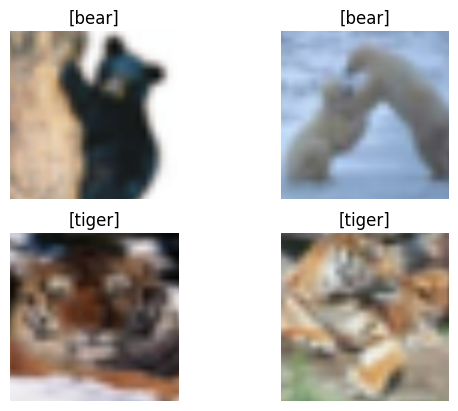

In [24]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

visualize_model(model_hybrid, num_images=4)


## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).
  
[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).